# Double DQN

I lernt from the following websites to finish the implementations.
Reference:
1. Hung-yi Lee. DRL Lecture 3: Q-learning (Basic Idea)
https://youtu.be/o_g9JUMw1Oc
2. Hung-yi Lee. DRL Lecture 4: Q-learning (Advanced Tips)
https://www.youtube.com/watch?v=2-zGCx4iv_k&t=980s
3. Tensorflow
https://www.tensorflow.org/api_docs/python/tf/keras/Model
4. Tom. Let's build a DQN: simple implementation
https://tomroth.com.au/dqn-simple/

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf
from random import sample

# Setting up the environment 
env = gym.make("CartPole-v0")

In [2]:
def create_model(name):
    input_layer = tf.keras.Input(shape = (4,))
    H1 = tf.keras.layers.Dense(32, activation='relu')(input_layer)
    H3 = tf.keras.layers.Dense(16, activation='relu')(H1)
    output_layer = tf.keras.layers.Dense(2)(H3)
    model = tf.keras.Model(inputs = input_layer, outputs = output_layer,name = name)
    model.compile(optimizer='adam',
                  loss="mse",
                  metrics=['accuracy'])
    model.summary()
    return model
model = create_model(name = "QNN")
# Target network
model2 = create_model(name = "TagretNetwork")



def replay(buffer, minibatch_size,timestep,epsoide_num):
    if timestep <= 500:
        return model
    else:
        minibatch = np.random.choice(buffer, minibatch_size, replace=False)
        s_l =      np.array(list(map(lambda x: x['s'], minibatch)))
        a_l =      np.array(list(map(lambda x: x['a'], minibatch)))
        r_l =      np.array(list(map(lambda x: x['r'], minibatch)))
        sprime_l = np.array(list(map(lambda x: x['sprime'], minibatch)))
        done_l   = np.array(list(map(lambda x: x['done'], minibatch)))
        current_qs = model.predict(s_l)
        Q_qnn = model.predict(sprime_l)
        Q_tgt = model2.predict(sprime_l)

        if epsoide_num % 10 == 0 and epsoide_num != 0:
            model2.set_weights(model.get_weights())   
        # q-update

        for i,(s,a,r,done,sprimeQnn,sprimeTgt) in enumerate(zip(s_l,a_l,r_l,done_l,Q_qnn,Q_tgt)):
            Q_DDQN = sprimeTgt[np.argmax(sprimeQnn)]
            if not done:  target = r + Q_DDQN
            else:         target = r
            # Update Q value for given state
            current_qs[i][a] = target
            # And append to our training data
        model.fit(s_l,current_qs,batch_size = minibatch_size,epochs=1,verbose=0)
        return model

Model: "QNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________
Model: "TagretNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
__________________________________________

In [3]:
from random import randrange

# hyper parameter
n_episodes = 2500
epsilon = 0.9
minibatch_size = 32
r_sums = []  # stores rewards of each epsiode 
buffer = [] # replay memory holds s, a, r, s'
win_weight_eps_tstep = []
mem_max_size = 10000
init_seed=123
timestep = 0
eps = 0
np.random.seed(123)


for n in range(n_episodes): 
    env.seed(seed=init_seed+n)
    s = env.reset()
    done=False
    r_sum = 0
    while not done: 
        # Uncomment this to see the agent learning
        # env.render()
        # Feedforward pass for current state to get predicted q-values for all actions 
        qvals_s = model.predict(s.reshape(1,4))
        # Choose action to be epsilon-greedy
        if np.random.random() < epsilon:  
            a = randrange(1)
        else:                             
            a = np.argmax(qvals_s)
        # Take step, store results 
        sprime, r, done, info = env.step(a)
        r_sum += r 
        # add to memory, respecting memory buffer limit 
        if len(buffer) > mem_max_size:
            buffer.pop(0)
        buffer.append({"s":s,"a":a,"r":r,"sprime":sprime,"done":done})
        # Update state
        s=sprime
        # Train the nnet that approximates q(s,a), using the replay memory
        model=replay(buffer, minibatch_size = minibatch_size, timestep = timestep, epsoide_num = n)
        # Decrease epsilon until we hit a target threshold 
        timestep += 1
        if timestep % 1000 == 0 and timestep != 0:
            print("timestep",timestep)   
    epsilon -= 0.001
    if epsilon <= 0.0005:
        eps += 0.001
        epsilon = 0.001
        if eps == 0.001:
            print("In the timestep of ", timestep, ", epsilon is fixed at",epsilon)     
    #print("Total reward:", r_sum)
    r_sums.append(r_sum)
    if n % 100 == 0 and n != 0: 
        print(n,"\n")
        print("r_score", np.round(np.mean(np.array(r_sums)), 3), "±", 2*np.round(np.std(np.array(r_sums)), 3), n+1, "trials. \n")
        print("rsums_lastest100",r_sums[-10:],"\n")

timestep 1000
100 

r_score 10.178 ± 3.31 101 trials. 

rsums_lastest100 [10.0, 10.0, 9.0, 9.0, 9.0, 11.0, 11.0, 13.0, 9.0, 10.0] 

timestep 2000
200 

r_score 12.279 ± 9.102 201 trials. 

rsums_lastest100 [16.0, 16.0, 16.0, 11.0, 13.0, 13.0, 22.0, 10.0, 12.0, 10.0] 

timestep 3000
timestep 4000
300 

r_score 14.219 ± 14.024 301 trials. 

rsums_lastest100 [12.0, 21.0, 22.0, 14.0, 15.0, 22.0, 14.0, 21.0, 21.0, 12.0] 

timestep 5000
timestep 6000
400 

r_score 16.264 ± 18.582 401 trials. 

rsums_lastest100 [20.0, 16.0, 21.0, 13.0, 25.0, 25.0, 32.0, 20.0, 33.0, 24.0] 

timestep 7000
timestep 8000
timestep 9000
500 

r_score 18.725 ± 23.73 501 trials. 

rsums_lastest100 [26.0, 42.0, 32.0, 58.0, 18.0, 27.0, 17.0, 55.0, 16.0, 33.0] 

timestep 10000
timestep 11000
timestep 12000
timestep 13000
timestep 14000
600 

r_score 23.468 ± 36.688 601 trials. 

rsums_lastest100 [15.0, 45.0, 75.0, 80.0, 93.0, 13.0, 19.0, 43.0, 65.0, 88.0] 

timestep 15000
timestep 16000
timestep 17000
timestep 18000
tim

Text(0, 0.5, 'Reward')

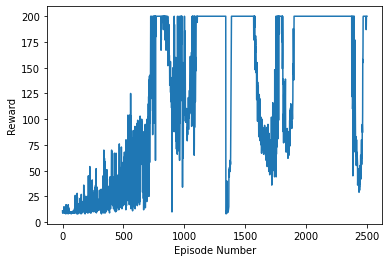

In [4]:
# Plot the performance of the agent 
plt.plot(r_sums)
plt.xlabel("Episode Number")
plt.ylabel("Reward")

In [5]:
import pickle
# Store data (serialize)
with open('cartpole_DDQN_final.pickle', 'wb') as handle:
    pickle.dump(r_sums +[timestep,], handle)

with open('cartpole_DDQN_final.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [7]:
timestep

312628

In [6]:
b[-1]

312628